In [3]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if base_path not in sys.path:
    sys.path.append(base_path)

import express.config as config
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.utils import add_names

In [4]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)
game_id = 3895302

df_actions = add_names(train_db.actions(game_id))
#display max columns
pd.set_option('display.max_columns', None)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x0000018B87AFF3E0>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x0000018B89026F30>


### 1 부채꼴 영역 내에서, 패스 경로를 방해하는 인원의 가우시안 분포 구하기

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from mplsoccer import Pitch
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
class SectorAnalysis:
    def __init__(self, freeze_frame, angle=45, player_idx=0,visualize=False):
        self.freeze_frame = freeze_frame
        self.angle = angle
        self.actor = next(player for player in freeze_frame if player['actor'])
        
        if not freeze_frame[player_idx]['teammate']:
            raise ValueError("Selected player is not a valid teammate.")
                
        self.teammate = freeze_frame[player_idx]        
        self.visualize = visualize
        self.opponents_in_sector = []
        self.Z = None

    def draw_pitch(self):
        if not self.visualize:
            return
        pitch = Pitch(pitch_type='statsbomb', label=True, pitch_color='grass', line_color='white')
        fig, ax = pitch.draw()
        
        # 각 플레이어 표시
        for idx, player in enumerate(self.freeze_frame):
            x, y = player['x'], player['y']
            if player['actor']:
                pitch.scatter(x, y, s=100, c='yellow', edgecolors='blue', marker='o', ax=ax)  # 공 소유자 강조
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가
            elif player['teammate']:
                pitch.scatter(x, y, s=100, c='blue', marker='o', ax=ax)  # 팀원 표시
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가
            else:
                pitch.scatter(x, y, s=100, c='red', marker='o', ax=ax)  # 상대 선수 표시
                ax.text(x, y, str(idx), fontsize=8, color='white', ha='center', va='center')  # 인덱스 레이블 추가

        # 부채꼴 그리기
        actor_x, actor_y = self.actor['x'], self.actor['y']
        teammate_x, teammate_y = self.teammate['x'], self.teammate['y']
        distance = ((teammate_x - actor_x) ** 2 + (teammate_y - actor_y) ** 2) ** 0.5
        direction_angle = np.degrees(np.arctan2(teammate_y - actor_y, teammate_x - actor_x))
        start_angle = direction_angle - self.angle / 2
        end_angle = direction_angle + self.angle / 2

        wedge = Wedge(center=(actor_x, actor_y), r=distance, theta1=start_angle, theta2=end_angle,
                      color="white", alpha=0.8, edgecolor="black")
        ax.add_patch(wedge)

        plt.show()

    def calculate_opponents_in_sector(self):
        # 부채꼴 내 상대 선수 필터링 및 거리와 각도 계산
        actor_x, actor_y = self.actor['x'], self.actor['y']
        baseline_angle = np.arctan2(self.teammate['y'] - actor_y, self.teammate['x'] - actor_x)
        distance = ((self.teammate['x'] - actor_x) ** 2 + (self.teammate['y'] - actor_y) ** 2) ** 0.5

        for player in self.freeze_frame:
            if not player['teammate']:  # 상대 선수만 필터링
                px, py = player['x'], player['y']
                angle_to_player = np.arctan2(py - actor_y, px - actor_x)
                angle_diff = angle_to_player - baseline_angle
                angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi

                # 부채꼴 안에 있는 선수 필터링
                if abs(angle_diff) <= np.radians(self.angle / 2):
                    dist_to_player = np.sqrt((px - actor_x) ** 2 + (py - actor_y) ** 2)
                    if dist_to_player <= distance:
                        self.opponents_in_sector.append((angle_diff, dist_to_player))

    def visualize_opponents(self):
        if not self.visualize:
            return  
        # 부채꼴 안에 있는 상대 선수들의 위치를 시각화
        fig, ax = plt.subplots(figsize=(8, 6))
        
        distance = ((self.teammate['x'] - self.actor['x']) ** 2 + (self.teammate['y'] - self.actor['y']) ** 2) ** 0.5
        max_distance = distance + 1  # y축 최대 범위 조정 (필요 시 조정)

        # teammate는 중앙(0, 거리)로 표시
        ax.scatter(0, distance, c='blue', s=200, label="Teammate", edgecolor='black')

        # opponent들을 angle_diff와 거리에 따라 표시
        for angle, dist in self.opponents_in_sector:
            ax.scatter(angle, dist, c='red', s=200, edgecolor='black')
            

        # 축 및 제목 설정
        ax.axvline(0, color='purple', linestyle='--', label='Path of pass')
        ax.set_xlim(-1.5, 1.5)  # x축을 동적으로 설정
        ax.set_ylim(0, max_distance)
        ax.set_xlabel('Angle from pass (radians)')
        ax.set_ylabel('Distance from pass')
        ax.set_title('Opponents in Sector (Angle vs Distance)')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def calculate_gaussian_distribution(self, sigma_x=0.2, sigma_y=3):
        # 각도와 거리 데이터를 기반으로 가우시안 분포 계산 후 그리드에 누적
        angles = np.array([angle for angle, _ in self.opponents_in_sector])
        distances = np.array([dist for _, dist in self.opponents_in_sector])

        x_bins = np.linspace(-1.5, 1.5, 20)
        y_bins = np.linspace(0, 50, 20)
        Z = np.zeros((len(y_bins) - 1, len(x_bins) - 1))


        # 가우시안 분포 계산
        for angle, dist in zip(angles, distances):
            for i in range(len(x_bins) - 1):
                for j in range(len(y_bins) - 1):
                    x_center = (x_bins[i] + x_bins[i + 1]) / 2
                    y_center = (y_bins[j] + y_bins[j + 1]) / 2
                    gaussian = np.exp(-(((x_center - angle) ** 2) / (2 * sigma_x ** 2) +
                                        ((y_center - dist) ** 2) / (2 * sigma_y ** 2)))
                    Z[j, i] += gaussian

        self.Z = Z
        self.x_bins = x_bins
        self.y_bins = y_bins

    def visualize_density(self):
        if not self.visualize:
            return 
        fig, ax = plt.subplots(figsize=(8, 6))
        c = ax.pcolormesh(self.x_bins, self.y_bins, self.Z, cmap='Reds', shading='auto', alpha=0.6)
        fig.colorbar(c, ax=ax)
        


        # Opponents와 Teammate 시각화
        ax.scatter(0, ((self.teammate['x'] - self.actor['x'])**2 + (self.teammate['y'] - self.actor['y'])**2)**0.5,
                   c='blue', s=200, label="Teammate", edgecolor='black', zorder=2)
        for angle, dist in self.opponents_in_sector:
            ax.scatter(angle, dist, c='red', s=200, edgecolor='black', zorder=2)

        # 각 셀의 값을 텍스트로 표시
        for i in range(len(self.x_bins) - 1):
            for j in range(len(self.y_bins) - 1):
                x_center = (self.x_bins[i] + self.x_bins[i + 1]) / 2
                y_center = (self.y_bins[j] + self.y_bins[j + 1]) / 2
                value = self.Z[j, i]
                if value > 0.01:
                    ax.text(x_center, y_center, f'{value:.2f}', color='white', ha='center', va='center', fontsize=8)

        ax.axvline(0, color='purple', linestyle='--', label='Path of pass', zorder=1)
        ax.set_xlim(-1.5, 1.5)

        ax.set_xlabel('Angle from pass (radians)')
        ax.set_ylabel('Distance from pass')
        ax.set_title('Gaussian Distribution of Opponents in Sector (Grid Representation)')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def get_column_sum(self):
        closest_index = np.abs(self.x_bins - 0).argmin()
        column_sum = self.Z[:, closest_index].sum()
        return column_sum


In [116]:
def analyze_all_teammates(freeze_frame, angle=45, visualize=False):
    # freeze_frame에서 teammate들만 필터링
    teammates = [i for i, player in enumerate(freeze_frame) if player['teammate'] and not player['actor']]
    
    results = []
    for idx in teammates:
        try:
            analysis = SectorAnalysis(freeze_frame, angle=angle, player_idx=idx, visualize=visualize)
            analysis.calculate_opponents_in_sector()
            analysis.calculate_gaussian_distribution()
            analysis.visualize_density()
            column_sum = analysis.get_column_sum()
            results.append({
                'teammate_index': idx,
                'column_sum': column_sum,
            })
        except ValueError as e:
            print(f"Skipping player at index {idx} - {e}")
    
    return results

In [117]:
test_frame = df_actions.loc[3895302, "freeze_frame_360"][4]
results = analyze_all_teammates(test_frame, angle=45, visualize=False)
print("\nResults:")
for result in results:
    print(f"Teammate index {result['teammate_index']} - Column Sum: {result['column_sum']:.2f}")


Results:
Teammate index 0 - Column Sum: 0.00
Teammate index 2 - Column Sum: 0.00
Teammate index 5 - Column Sum: 2.69
Teammate index 6 - Column Sum: 1.13
Teammate index 8 - Column Sum: 0.86
Teammate index 10 - Column Sum: 3.59
Teammate index 11 - Column Sum: 4.19
Teammate index 12 - Column Sum: 1.19


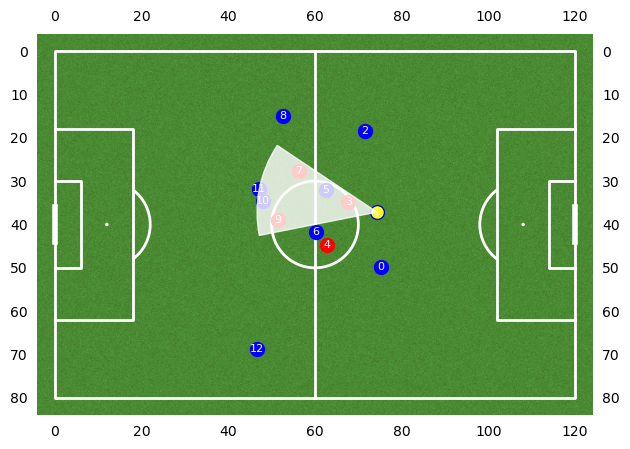

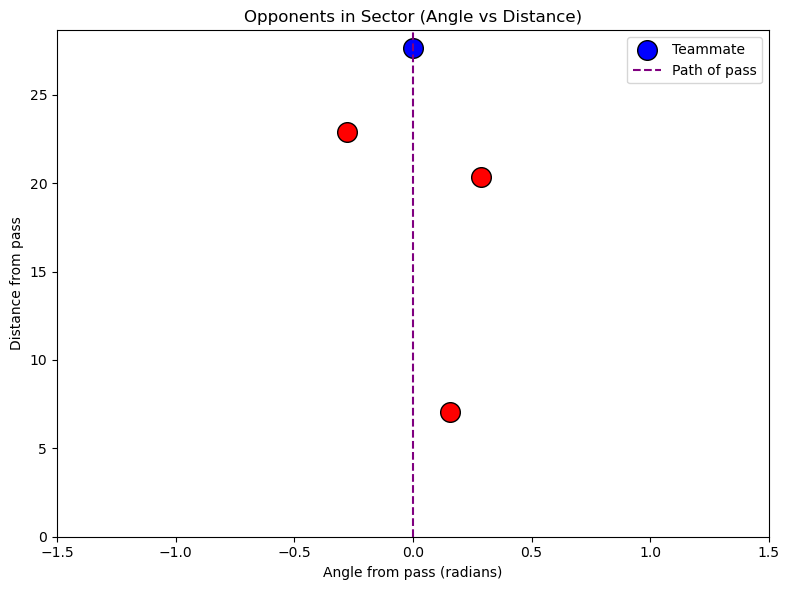

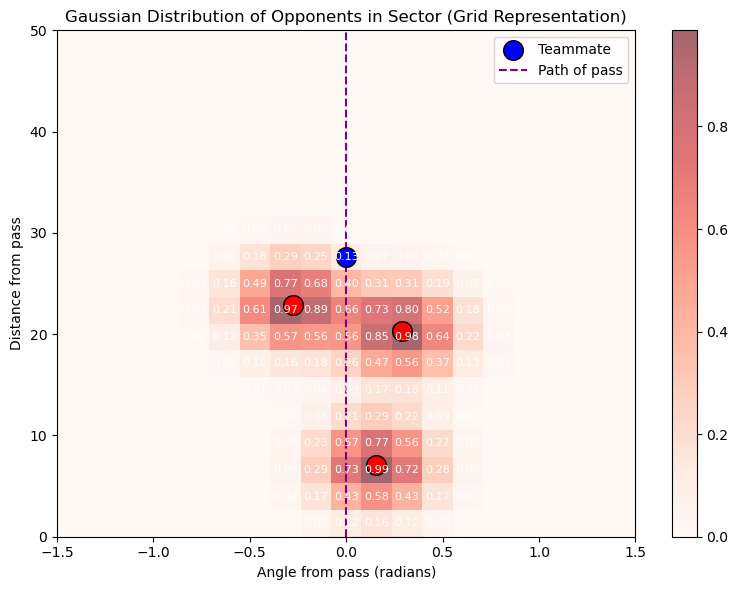

4.189862053884408

In [118]:
freeze_frame = df_actions.loc[3895302, "freeze_frame_360"][4]

sector_analysis = SectorAnalysis(freeze_frame,angle=45, player_idx=11, visualize=True)
sector_analysis.draw_pitch()
sector_analysis.calculate_opponents_in_sector()
sector_analysis.visualize_opponents()
sector_analysis.calculate_gaussian_distribution(sigma_x=0.2, sigma_y=3)
sector_analysis.visualize_density()
sector_analysis.get_column_sum()

### 2 나와의 거리 고려

In [ ]:
df_actions.head(5)

In [36]:
import numpy as np


# actor의 위치 찾기
actor_location = next(player for player in freeze_frame if player['actor'])
actor_x, actor_y = actor_location['x'], actor_location['y']

# 각 teammate와 actor 간의 거리 계산
distances = []
for idx, player in enumerate(freeze_frame):
    if player['teammate'] and not player['actor']:  # actor가 아닌 teammate에 대해서만 계산
        distance = np.sqrt((player['x'] - actor_x) ** 2 + (player['y'] - actor_y) ** 2)
        distances.append({
            'idx': idx,
            'teammate_x': player['x'],
            'teammate_y': player['y'],
            'distance_from_actor': distance
        })

# 결과 출력
for teammate in distances:
    print(f"Teammate_{teammate['idx']} at ({teammate['teammate_x']}, {teammate['teammate_y']}) is {teammate['distance_from_actor']:.2f} units away from the actor.")


Teammate_0 at (75.2918078047923, 49.90099281939237) is 12.80 units away from the actor.
Teammate_2 at (71.48317144334712, 18.342054250221686) is 19.01 units away from the actor.
Teammate_5 at (62.590600191527, 31.96355472302257) is 12.79 units away from the actor.
Teammate_6 at (60.172092601573816, 41.7182290458351) is 14.84 units away from the actor.
Teammate_8 at (52.50840447140194, 14.917997335771261) is 31.12 units away from the actor.
Teammate_10 at (47.9428015027403, 34.671239087285514) is 26.46 units away from the actor.
Teammate_11 at (47.17304768960261, 31.738556021550117) is 27.65 units away from the actor.
Teammate_12 at (46.64461585253179, 68.68141456707403) is 41.94 units away from the actor.


### 3 골대와의 거리 고려

In [39]:
import numpy as np

# actor의 위치 찾기
actor_location = next(player for player in freeze_frame if player['actor'])
actor_x, actor_y = actor_location['x'], actor_location['y']
#freeze_frame = df_actions.loc[3895302, "freeze_frame_360"][4]

# game_id로 팀 정보 불러오기
if df_actions.loc[3895302, "freeze_frame_360"][4] == train_db.get_home_away_team_id(game_id)[0]:
    goal_center = (120, 40)  # 홈팀의 골대 중앙 좌표
else:
    goal_center = (0, 40)  # 원정팀의 골대 중앙 좌표
    
# 각 teammate와 actor 간의 거리 및 각도 계산
angles_and_distances = []
for idx,player in enumerate(freeze_frame):
    if player['teammate'] and not player['actor']:  # actor가 아닌 teammate에 대해서만 계산
        # 골대와의 거리 계산
        distance_from_goal = np.sqrt((player['x'] - goal_center[0]) ** 2 + (player['y'] - goal_center[1]) ** 2)
        
        angles_and_distances.append({
            'idx': idx,
            'teammate_x': player['x'],
            'teammate_y': player['y'],
            'distance_from_goal': distance_from_goal
        })

# 결과 출력
for teammate in angles_and_distances:
    print(f"Teammate_{teammate['idx']} at ({teammate['teammate_x']}, {teammate['teammate_y']}) is "
          f"{teammate['distance_from_goal']:.2f} units away from the goal")


Teammate_0 at (75.2918078047923, 49.90099281939237) is 75.94 units away from the goal
Teammate_2 at (71.48317144334712, 18.342054250221686) is 74.69 units away from the goal
Teammate_5 at (62.590600191527, 31.96355472302257) is 63.10 units away from the goal
Teammate_6 at (60.172092601573816, 41.7182290458351) is 60.20 units away from the goal
Teammate_8 at (52.50840447140194, 14.917997335771261) is 58.19 units away from the goal
Teammate_10 at (47.9428015027403, 34.671239087285514) is 48.24 units away from the goal
Teammate_11 at (47.17304768960261, 31.738556021550117) is 47.89 units away from the goal
Teammate_12 at (46.64461585253179, 68.68141456707403) is 54.76 units away from the goal


## 총정리

In [ ]:
import numpy as np

class FrameAnalyzer:
    '''
    공을 잡은 상황에서, 팀 동료의 위치와 패스 경로에 대한 압박 정보를 기반으로 패스 수신자를 예측하는 클래스
    '''
    def __init__(self, db, game_id, action_index, visualize=False):
        self.frame = df_actions.loc[game_id, "freeze_frame_360"][action_index]
        self.df_actions = add_names(db.actions(game_id))
        self.db = db
        self.game_id = game_id
        self.visualize = visualize
        self.actor_location = next(player for player in self.frame if player['actor'])
        self.actor_x, self.actor_y = self.actor_location['x'], self.actor_location['y']
    
    def get_distance_to_goal(self):
        '''
        가능한 패스 수신자로부터 공격방향 쪽 골대까지의 거리를 계산
        '''
        home_team_id, _ = self.db.get_home_away_team_id(self.game_id)
        possession_team_id = self.df_actions.loc[self.game_id, "possession_team_id"][0]
        goal_center = (120, 40) if home_team_id == possession_team_id else (0, 40)
        distance_from_goal = {}
        
        for idx, player in enumerate(self.frame):
            if player['teammate'] and not player['actor']:
                distance = np.sqrt((player['x'] - goal_center[0]) ** 2 + (player['y'] - goal_center[1]) ** 2)
                distance_from_goal[idx] = distance
        return distance_from_goal

    def get_distance_between_actor_teammates(self):
        '''
        가능한 수신자로부터 actor와의 거리를 계산
        '''
        distances_between_us = {}
        for idx, player in enumerate(self.frame):
            if player['teammate'] and not player['actor']:
                distance = np.sqrt((player['x'] - self.actor_x) ** 2 + (player['y'] - self.actor_y) ** 2)
                distances_between_us[idx] = distance
        return distances_between_us

    def calculate_column_sum(self, angle=45):
        ''' 
        가능한 패스 경로에 대한 압박 정보를 계산
        '''
        
        teammates = [i for i, player in enumerate(self.frame) if player['teammate'] and not player['actor']]
        column_sums = {}
        
        for idx in teammates:
            try:
                analysis = SectorAnalysis(self.frame, angle=angle, player_idx=idx, visualize=self.visualize)
                analysis.calculate_opponents_in_sector()
                analysis.calculate_gaussian_distribution()
                column_sum = analysis.get_column_sum()
                column_sums[idx] = column_sum
                
                # 추가 시각화
                if self.visualize:
                    self.visualize_all(analysis)  # 모든 시각화 호출
            except ValueError as e:
                print(f"Skipping player at index {idx} - {e}")
        
        return column_sums

    def visualize_all(self, analysis):
        '''        
        SectorAnalysis의 시각화 순차적으로 호출
        '''
        analysis.draw_pitch()
        analysis.visualize_opponents()
        analysis.visualize_density()
    
    def get_top_n_teammates(self, n=3):
        '''
        주어진 기준에 따라 최상위 n명의 팀 동료를 반환
        '''
        
        distance_to_goal = self.get_distance_to_goal()
        distance_from_actor = self.get_distance_between_actor_teammates()
        column_sums = self.calculate_column_sum()

        scores = {
            idx: 1 / (1 + distance_to_goal[idx]) + 1 / (1 + distance_from_actor[idx]) + (1 - column_sums[idx])
            for idx in distance_to_goal
        }

        top_n_teammates = sorted(scores, key=scores.get, reverse=True)[:n]
        
        return top_n_teammates


In [ ]:
frame_analyzer = FrameAnalyzer(db=train_db, game_id=3895302, action_index=1055, visualize=True)
frame_analyzer.get_top_n_teammates(n=3)

In [158]:
import pandas as pd
import numpy as np

def get_action_teammate_features(game_id, train_db, action_index, n=3):
    """
    위에서 고안된 로직에 의해 추출된 N명의 Teammates들에 대한 거리와 각도를 반환합니다.
    
    
    Parameters
    ----------
    game_id : int
        The ID of the game.
    train_db : Database
        The database containing game data.
    action_index : int
        The index of the action to analyze.
    n : int, optional, default=3
        The number of closest teammates to analyze.
        
    Returns
    -------
    pd.DataFrame
        A single-row DataFrame with columns for each teammate's distance and angle:
        ['closest_1_distance', 'closest_1_radian', 'closest_2_distance', 'closest_2_radian', ...].
    """
    # FrameAnalyzer 객체 생성
    frame_analyzer = FrameAnalyzer(db=train_db, game_id=game_id, action_index=action_index)
    top_teammates = frame_analyzer.get_top_n_teammates(n=n)

    # 현재 actor의 위치를 가져옴
    actor_x, actor_y = frame_analyzer.actor_x, frame_analyzer.actor_y
    angle_distance_info = []

    # N명의 Teammates에 대한 거리와 각도 계산
    for idx in top_teammates:
        teammate = frame_analyzer.frame[idx]
        teammate_x, teammate_y = teammate['x'], teammate['y']

        
        distance = np.sqrt((teammate_x - actor_x) ** 2 + (teammate_y - actor_y) ** 2)
        angle = np.arctan2(teammate_y - actor_y, teammate_x - actor_x)

        angle_distance_info.append((distance, angle))

    # N명의 Teammates가 없을 경우 NaN으로 채움
    while len(angle_distance_info) < n:
        angle_distance_info.append((np.nan, np.nan))

    # dictionary로 변환
    action_data = {}
    for i, (distance, angle) in enumerate(angle_distance_info, start=1):
        action_data[f'closest_{i}_distance'] = distance
        action_data[f'closest_{i}_radian'] = angle

    # DataFrame으로 변환
    return pd.DataFrame([action_data], index=[action_index])




In [159]:
get_action_teammate_features(game_id=3895302, train_db=train_db, action_index=1055, n=3)


,closest_1_distance,closest_1_radian,closest_2_distance,closest_2_radian,closest_3_distance,closest_3_radian
1055,9.878594,2.684016,9.36923,-0.964124,14.866068,1.612023


In [ ]:
df_actions["get_action_teammate_features"] = get_action_teammate_features(df_actions, train_db,n=3)["get_action_teammate_features"]

print(df_actions[[ "possession_team_id", "type_name","result_name",  "get_action_teammate_features"]].head(10))
